# Multi-Frame Motion Deblur Path Analysis
This notebook generates a simulation object, solves the linear inverse problem, and analyzes the quality ofthe blur path.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import time
import sys
import itertools
import math
import imageio
import skimage as sk

# Libwallerlab imports
from libwallerlab.algorithms import iterative as iterative
from libwallerlab.opticsalgorithms.motiondeblur import blurkernel 
from libwallerlab.operators import operators as ops
from libwallerlab.utilities import displaytools, iotools

from libwallerlab.algorithms import objectivefunctions
from libwallerlab.algorithms import regularizers
from libwallerlab.operators import proximal as proxops
from libwallerlab.utilities.opticstools import Ft, iFt

## Flow of Notebook
1. Generate Object
2. Generate Measurements (Images)
3. Solve Inverse Problem
4. Save measurements and blur kernels in accurate libwallerlab.utilities.iotools.Dataset format

### To-Do
- // linear_y kernels don't extend whole way
- // multi-pass kernels
- // Add Sarah's PGD kernel optimization methods
- // Find out why result is not converging to correct values
- // save/load to lwl dataset format
- Add nesterov acceleration
- Implement CG
- Implement FISTA
- clean up blurkernel.py

# Define Motion Blur Parameters

In [2]:
# Image to use when generating object
object_file_name = '../../../../../common/test_images/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Illumination vector generation type
blur_vector_type = 'random_phase' # 'random_phase' # can be strobe, constant, random, random_phase, projected_gradient_descent

# Motion scanning type
scan_type = 'raster' # can be linear_x, linear_y, raster, (add more here)

# Flag to scan entire object in multiple times (True) or in individual segments of a single pass (False)
full_object_multi_pass = 0

# Method of padding object (for convolution support)
object_edge_pad_type = 'mean'

# Use spectrally-variant blur kernel (single-led flickering)

## NOT WORKING YET ##
use_spectrally_variant_blur = False

# Illumination throughput coefficient ( \in [0,1] )
throughput_coefficient = 0.5

# Image size to simulate
image_size = np.array([32, 32])

# Object size to image size ratio (>=1, integer)
object_size_ratio = 3

# Redundancy in measurements (> 1 means extra pixels are recorded, <1 means not enough)
measurement_redundancy = 1

# Directory to save output in
simulation_output_dir = '/home/sarah/Dropbox/deblurring/COSI/data/simulations/blurred'
# '/Users/zfphil/develop/datasets/'

# Generate Object

## Load Object

Object size is 96 x 96


/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<IPython.core.display.Javascript object>


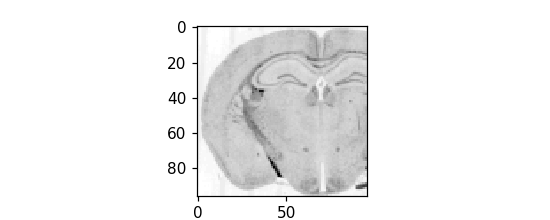

In [3]:
# Load object
brain = imageio.imread(object_file_name)

# Generate object with correct size
object_size_0 = np.round(np.array([object_size_ratio * image_size[0], object_size_ratio * image_size[1] * (brain.shape[1] / brain.shape[0])])).astype(np.int) # image_size #* 3
# brain_cropped = misc.imresize(brain, size=object_size_0) / 255.
brain_cropped = misc.imresize(brain, size=object_size_0) / 255.

# Determine object size
if scan_type == 'linear_y':
    brain_cropped = brain_cropped[:image_size[0]*object_size_ratio, :image_size[1]]
elif scan_type in ['linear', 'linear_x']:
    brain_cropped = brain_cropped[:image_size[0], :image_size[1]*object_size_ratio]
elif scan_type in ['raster', 'raster_major_both', 'raster_major_y', 'raster_2x']:
    brain_cropped = brain_cropped[:image_size[0]*object_size_ratio, :image_size[1]*object_size_ratio]

# Redefine object size
# new_size = np.round([object_size_0[0], object_size_0[0] * (brain.shape[1] / brain.shape[0])]).astype(np.int)
object_color_channel = 2 # Choose one of RGB channels (TODO: implement color)
object_true = brain_cropped[:, :, object_color_channel] # remove alpha
object_size_0 = object_true.shape[:2]
print("Object size is %d x %d" % (object_size_0[0], object_size_0[1]))

# Plot
plt.figure(figsize = (5,2))
plt.imshow(object_true, cmap='gray')
# plt.axis('off')

# Generate Blur Pathway

In [7]:

point_list_segmented

[array([[16,  0],
        [16,  1],
        [16,  2],
        [16,  3],
        [16,  4],
        [16,  5],
        [16,  6],
        [16,  7],
        [16,  8],
        [16,  9],
        [16, 10],
        [16, 11],
        [16, 12],
        [16, 13],
        [16, 14],
        [16, 15],
        [16, 16],
        [16, 17],
        [16, 18],
        [16, 19],
        [16, 20],
        [16, 21],
        [16, 22],
        [16, 23],
        [16, 24],
        [16, 25],
        [16, 26],
        [16, 27]]), array([[16, 28],
        [16, 29],
        [16, 30],
        [16, 31],
        [16, 32],
        [16, 33],
        [16, 34],
        [16, 35],
        [16, 36],
        [16, 37],
        [16, 38],
        [16, 39],
        [16, 40],
        [16, 41],
        [16, 42],
        [16, 43],
        [16, 44],
        [16, 45],
        [16, 46],
        [16, 47],
        [16, 48],
        [16, 49],
        [16, 50],
        [16, 51],
        [16, 52],
        [16, 53],
        [16, 54],
        [

In [5]:
object_size_0

(96, 96)

In [6]:
point_list_segmented = blurkernel.genRasterMotionPathway(object_size_0, image_size)

# Generate illumination vectors using quick and cheap optimization
blur_vector_type = 'random_phase'
illum_vector_list = []
for kernel_index, positions in enumerate(point_list_segmented):
    if blur_vector_type == 'constant':
        illum_vector_list.append(np.ones(positions.shape[0]))
    elif blur_vector_type == 'strobe':
        illum_vector_list.append(np.zeros(positions.shape[0]))
        illum_vector_list[-1][positions.shape[0] // 2] = throughput_coefficient
    elif blur_vector_type == 'random':
        illum_vector_list.append(np.random.rand(positions.shape[0]))
        illum_vector_list[-1] = illum_vector_list[-1] / np.sum(illum_vector_list[-1]) * throughput_coefficient
    elif blur_vector_type == 'random_phase':
        k, v = blurkernel.genIllum_pseudoRandom_len(len(positions))
        illum_vector_list.append(v)
    elif blur_vector_type == 'projected_gradient_descent':
        blur_kernel_fourier = blurkernel.positionListToBlurKernelMap(object_size_0, positions, return_fourier=True)
        def blurMapCol(i):
            return (blur_kernel_fourier[i]).reshape(-1) #/ len(positions)
        result = blurkernel.genIllum(blurMapCol, len(blur_kernel_fourier),  
                                     maxiter=100, throughputCoeff=throughput_coefficient, 
                                     resultType='final', verbose=False)
        illum_vector_list.append(result['xopt'])
        print('kernel %d has length %d and condition number %.2f' % (kernel_index, len(positions), result['fopt']))
    else:
        raise NotImplementedError('Illumination vector type %s is not implemented.' % blur_vector_type)
print(len(point_list_segmented))
# Generate blur kernel maps for each frame
blur_kernel_list = np.zeros((len(point_list_segmented), object_size_0[0], object_size_0[1]))
for frame_index in range(len(illum_vector_list)):
    for position_index, position in enumerate(point_list_segmented[frame_index]):
        blur_kernel_list[frame_index, position[0], position[1]] = illum_vector_list[frame_index][position_index]

# Define cropped object sizes and crop true image
object_size = blur_kernel_list[0].shape

# Show blur kernels
displaytools.show3dArray(blur_kernel_list, figsize=(8,6))

Image size requires 3 x 3 images
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
9


IndexError: index 96 is out of bounds for axis 1 with size 96

<IPython.core.display.Javascript object>


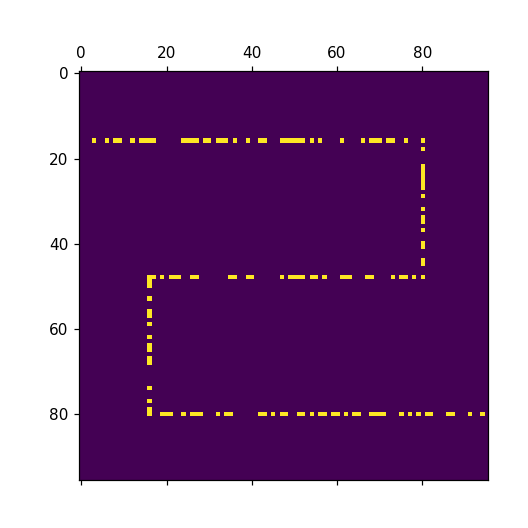

In [63]:
plt.matshow(sum(blur_kernel_list))

# Quality of Blur Kernel

<IPython.core.display.Javascript object>


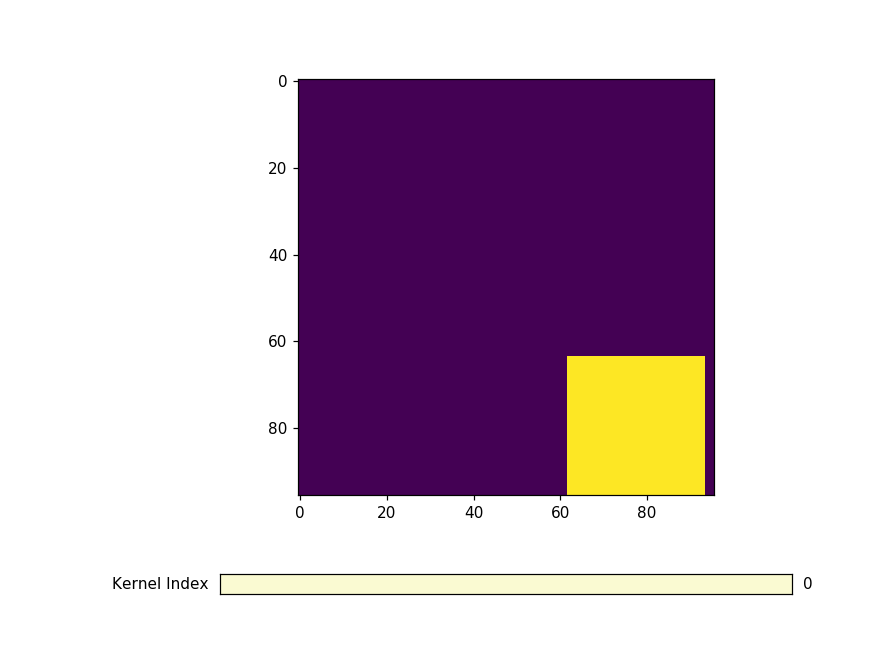

/home/sarah/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [68]:
from libwallerlab.utilities.opticstools import iFt, Ft

# Generate windowed coverage for each frame

midpoint_list = []
weighted_midpoint_list = []
for frame_index, point_list in enumerate(point_list_segmented):
    nonzero_illum = np.where(illum_vector_list[frame_index].reshape(-1) != 0)
    included_point_list = point_list[np.min(nonzero_illum):(np.max(nonzero_illum)+1)]
    # weighted_midpoint_list.append(np.round(np.average(point_list, axis=0, \
    #                                                  weights=illum_vector_list[frame_index].reshape(-1)).astype(np.int)))
    midpoint_list.append(np.round(np.mean(point_list, axis=0)).astype(np.int))
    weighted_midpoint_list.append(np.round(np.mean(included_point_list, axis=0)).astype(np.int))

midpoint_kernel_list = np.zeros((len(midpoint_list), object_size_0[0], object_size_0[1]))
weighted_midpoint_kernel_list = np.zeros((len(midpoint_list), object_size_0[0], object_size_0[1]))
for frame_index in range(len(illum_vector_list)):
    position = midpoint_list[frame_index]
    weighted_position = weighted_midpoint_list[frame_index]
    midpoint_kernel_list[frame_index, position[0], position[1]] = 1
    weighted_midpoint_kernel_list[frame_index, weighted_position[0], weighted_position[1]] = 1

_, object_support_mask = blurkernel.genConvolutionSupportList(midpoint_kernel_list, image_size, threshold=1e-2)
_, object_support_mask_weighted = blurkernel.genConvolutionSupportList(weighted_midpoint_kernel_list, image_size, threshold=1e-2)

displaytools.show3dArray(object_support_mask_weighted, figsize=(8,6))

sv_spectrum = []
for blur_kernel in blur_kernel_list:
    svs = np.abs(Ft(blur_kernel.astype(np.complex64)))**2
    sv_spectrum.append(svs)

In [69]:
np.mean(point_list_segmented[2],axis=0)
print(midpoint_list)

[array([16, 16]), array([16, 48]), array([16, 80]), array([48, 81]), array([48, 48]), array([48, 16]), array([80, 15]), array([80, 48]), array([80, 80])]


<IPython.core.display.Javascript object>


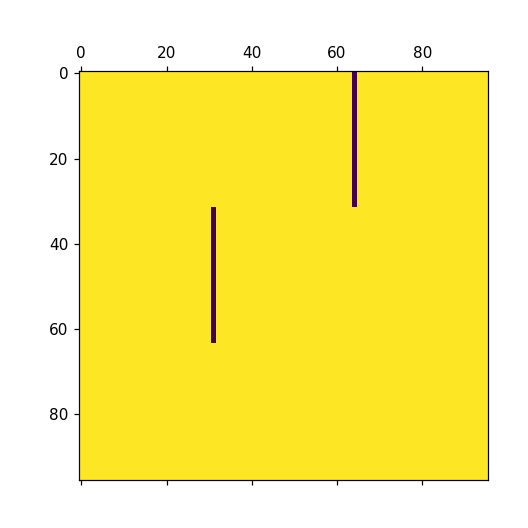

In [70]:
plt.matshow(sum(object_support_mask))

In [19]:
## spatially varying singular value list
spatial_svs = np.zeros([object_size[0], object_size[1], np.prod(object_size)])
for frame_index in range(len(blur_kernel_list)):
    spatial_svs[object_support_mask[frame_index],:] += sv_spectrum[frame_index].reshape(-1)
    
spatial_svs_weighted = np.zeros([object_size[0], object_size[1], np.prod(object_size)])
for frame_index in range(len(blur_kernel_list)):
    spatial_svs_weighted[object_support_mask_weighted[frame_index],:] += sv_spectrum[frame_index].reshape(-1)

/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


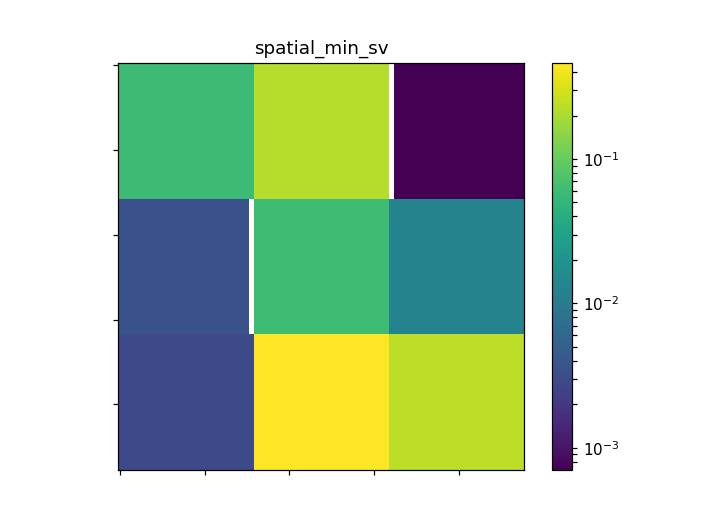

<IPython.core.display.Javascript object>


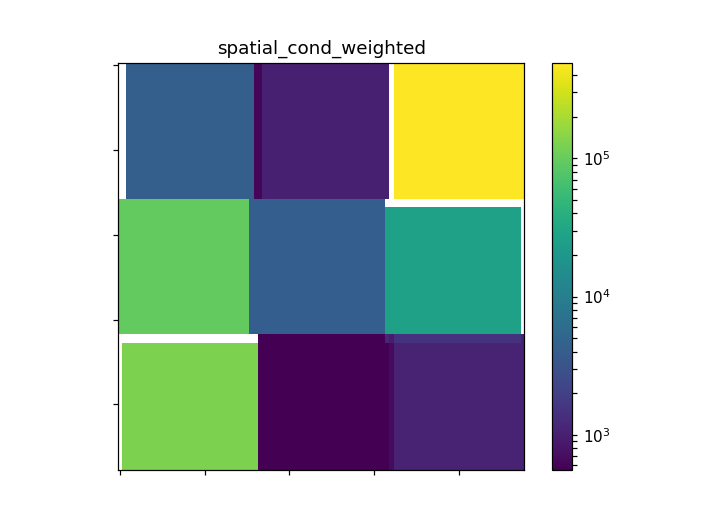

In [36]:
from matplotlib.colors import LogNorm

spatial_min_sv = np.amin(spatial_svs, axis=2)
spatial_max_sv = np.amax(spatial_svs, axis=2)
spatial_cond = np.divide(spatial_max_sv, spatial_min_sv)

spatial_min_sv_weighted = np.amin(spatial_svs_weighted, axis=2)
spatial_max_sv_weighted = np.amax(spatial_svs_weighted, axis=2)
spatial_cond_weighted = np.divide(spatial_max_sv_weighted, spatial_min_sv_weighted)

for toplot in ['spatial_min_sv', 'spatial_cond_weighted']:
    plt.figure(); plt.imshow(eval(toplot), cmap='viridis',norm=LogNorm()); 
    plt.colorbar(); plt.tick_params(labelbottom='off',labelleft='off'); plt.title(toplot)

# Confirmation of Quality via Simulation:
## Measurement generations

In [32]:
noise_magnitude = 0# 1e-8
noise_type = 'shot'

<IPython.core.display.Javascript object>


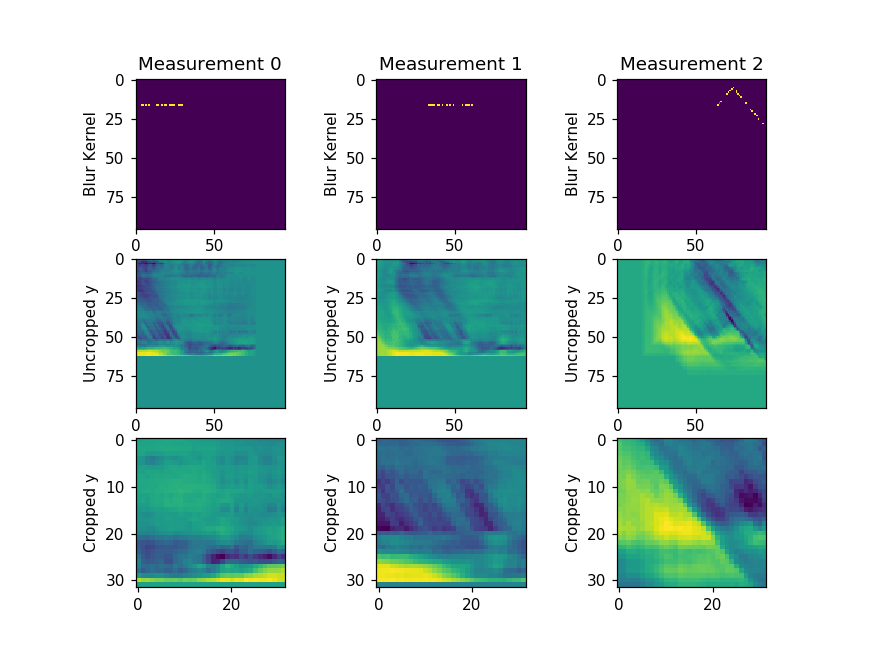

In [33]:
# Determine maximum kernel support in x/y for all blur kernels in blur_kernel_list. This is how much we will pad our object by.
support_size_list = []
for blur_kernel in blur_kernel_list:
#     support_size_list.append(blurkernel.getBoundingBox(blur_kernel, return_roi=True).size())
    support_size_list.append(blurkernel.getPositionListBoundingBox(point_list_segmented).size())
max_kernel_support = np.max(np.asarray(support_size_list),axis=0)

# Generate pad operator for object support
object_size_padded = (np.asarray(object_size) + max_kernel_support).tolist() # Add to object_size
W_object_support = ops.Crop(object_size_padded, object_size, crop_start=(max_kernel_support[0] // 2, max_kernel_support[1] // 2)) # Add support

# Pad object with random values (to simulate an extended object)
object_extended = W_object_support.H * object_true.reshape(-1).astype(np.complex64)
if object_edge_pad_type == 'random':
    object_extended += (1. - W_object_support.H * np.ones(object_true.size, dtype=np.complex64)) * np.random.rand(np.prod(object_size_padded))
elif object_edge_pad_type == 'zeros':
    object_extended += (1. - W_object_support.H * np.zeros(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == 'ones':
    object_extended += (1. - W_object_support.H * np.ones(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == 'mean':
    object_extended += (1. - W_object_support.H * np.mean(object_true) * np.ones(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == None:
    object_extended = object_true
    object_size_padded = object_true.shape
    W_object_support = ops.Identity(object_true.shape)
    
# Define crop operator for object to image
W = ops.Crop(object_size, image_size)

A_list = []
y_list = []
C_list = []
y_list_uncropped = []

# Generate forward model operators for each blur kernel
for blur_kernel_index, blur_kernel in enumerate(blur_kernel_list):
    blur_kernel = blur_kernel.astype(np.complex64) / np.sum(np.abs(blur_kernel.astype(np.complex64)))
    
    # 2D Convolution Operator with the given kernel
    C = ops.Convolution(object_size_padded, (W_object_support.H * blur_kernel.reshape(-1)).reshape(object_size_padded))
    C_list.append(C)
    
    # Forward operator with image crop and full object crop
    A_list.append(W * W_object_support * C)
    
    # Generate measurements using padded convolution
    y_list.append(A_list[-1] * object_extended.reshape(-1).astype(np.complex64))
    
    # Store uncropped measurements so we can observe what the padding is actually doing
    y_list_uncropped.append(W_object_support * C * object_extended.reshape(-1).astype(np.complex64))
    
# Show first three blur kernels, uncropped measurements, and cropped measurements
plt.figure(figsize=(8,6))
nshow = min(3, len(blur_kernel_list))
for i in range(nshow):
    plt.subplot(3, nshow, i+1)
    plt.imshow(blur_kernel_list[i], interpolation='none')
    plt.title('Measurement '+str(i))
    plt.ylabel('Blur Kernel')
    
    plt.subplot(3, nshow, nshow + i + 1)
    plt.imshow(np.abs(y_list_uncropped[i].reshape(object_size)))
    plt.ylabel('Uncropped y')
    
    plt.subplot(3, nshow, nshow*2 + i + 1)
    plt.imshow(np.abs(y_list[i].reshape(image_size)))
    plt.ylabel('Cropped y')

# Recovery via Gradient Descent

In [34]:
y_list_noise = []
for y in y_list:
    noise = noise_magnitude * np.random.normal(size=y.shape)
    if noise_type == 'shot': noise = noise * y
    y_list_noise.append((y + noise).astype(np.float32))

# Generate measurements from image list
y_full = np.empty(0, dtype=np.complex64)
for y in y_list_noise:
    y_full = np.append(y_full, y)
    
# Normalize measurements
y_mean = np.mean(np.abs(y_full))  
y_full /= y_mean

# Generate full A Operator
A_full = ops.Vstack(Operators=A_list)

# Initialization: choosing a "good" coefficient value will help in convergence
initialization = np.ones(object_size_padded, dtype=np.complex64).reshape(-1)

# Define cost function
objective = objectivefunctions.L2(A_full, y_full)

solve_method = 'gd'
display_type = 'text'
# Solve linear inverse problem

if solve_method is 'gd':
    iteration_count = 300
    object_recovered = iterative.GradientDescent(objective).solve(initialization=initialization, 
                                                                  step_size=1,
                                                                  iteration_count=iteration_count, 
                                                                  display_type=display_type, 
                                                                  display_iteration_delta=(iteration_count // 10))
elif solve_method is 'cg':
    iteration_count = 300
    object_recovered = iterative.ConjugateGradient(A_full, y_full).solve(initialization=initialization, 
                                                                  iteration_count=iteration_count, 
                                                                  display_type=display_type,
                                                                  use_log_y=False,
                                                                  use_log_x=False,
                                                                  debug=True,
                                                                  display_iteration_delta=(iteration_count // 10))
elif solve_method is 'fista':
    iteration_count = 300

    object_recovered = iterative.Fista(objective, proximal_operator=proxops.positivity).solve(initialization=initialization, 
                                                                                              iteration_count=iteration_count, 
                                                                                              display_type=display_type,
                                                                                              use_log_y=True,
                                                                                              use_log_x=False,
                                                                                              debug=True,
                                                                                              display_iteration_delta=(iteration_count // 10))

/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: ComplexWarning: Casting complex values to real discards the imaginary part


|  Iter  |      Cost      | Elapsed time (sec) |
+ ------ + -------------- + ------------------ +
|    0   |    1.17e+00    |        0.00        |
|   30   |    4.99e-03    |        4.59        |
|   60   |    1.76e-03    |        9.18        |
|   90   |    9.18e-04    |       14.26        |
|  120   |    5.74e-04    |       18.81        |
|  150   |    3.96e-04    |       23.36        |
|  180   |    2.90e-04    |       27.91        |
|  210   |    2.22e-04    |       32.43        |
|  240   |    1.75e-04    |       36.96        |
|  270   |    1.42e-04    |       41.48        |
|  300   |    1.17e-04    |       46.18        |


## Show Results

Recovery SSE is 1.41


<IPython.core.display.Javascript object>


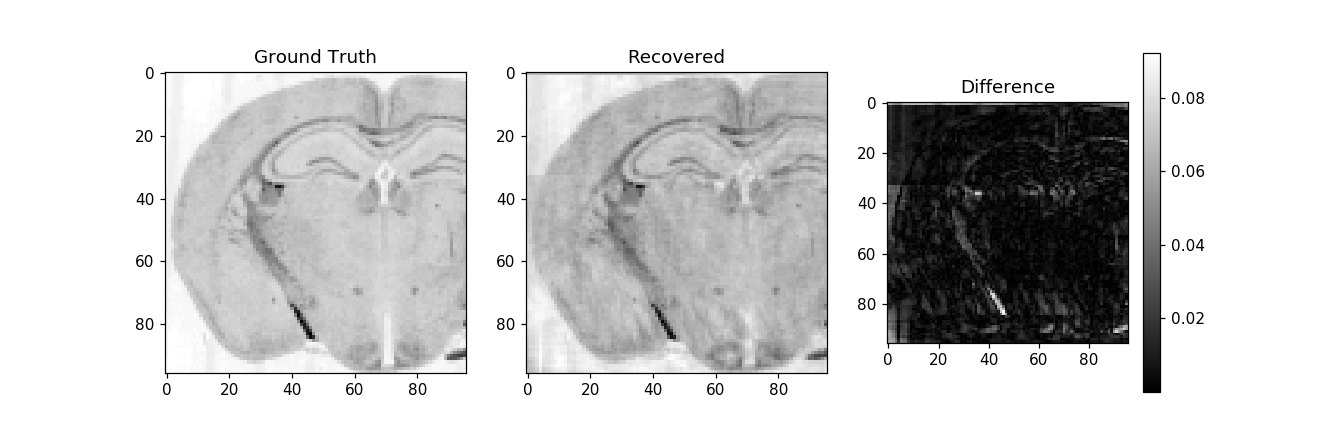

In [35]:
object_recovered_crop = (W_object_support * object_recovered).reshape(object_size)

# normalize true object (because zero-frequency is irrelevent and recon is zero-mean)
object_true_normalized = object_true / np.mean(object_true)
object_recovered_crop = object_recovered_crop / np.mean(object_recovered_crop)
# Calculate SSE
print('Recovery SSE is %.2f' % np.sum(np.abs(object_true_normalized - object_recovered_crop) ** 2))

plt.figure(figsize=(12, 4)) 
plt.subplot(1,3,1); i_true = plt.imshow(np.abs(object_true_normalized), cmap='gray'); plt.title('Ground Truth')
plt.subplot(1,3,2); i_rec = plt.imshow(np.abs(object_recovered_crop), cmap='gray'); plt.title('Recovered');# i_rec.set_clim(i_true.get_clim())
plt.subplot(1,3,3); plt.imshow(np.abs(object_true_normalized - object_recovered_crop), cmap='gray'); plt.colorbar(); plt.title('Difference')

<IPython.core.display.Javascript object>


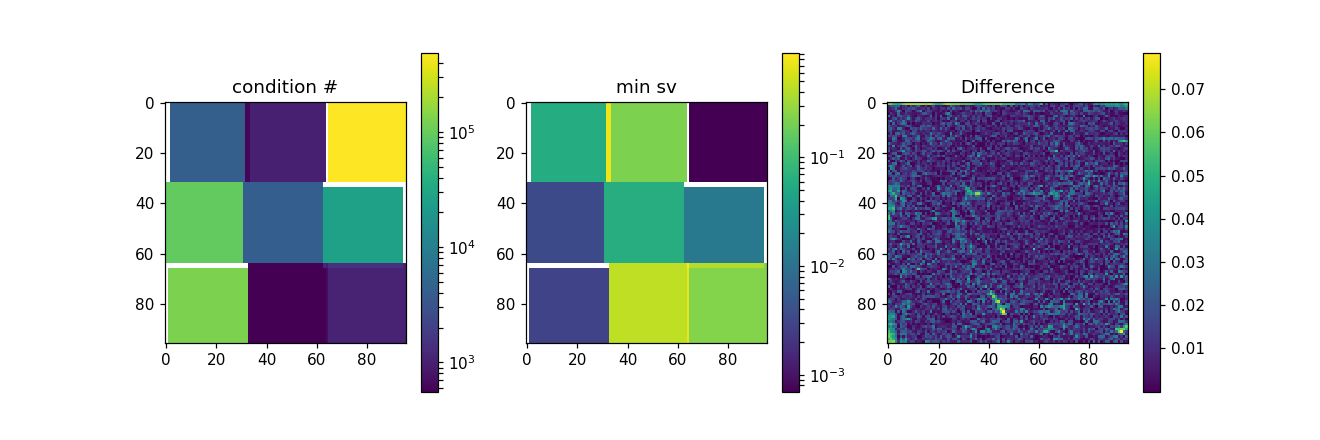

In [25]:
plt.figure(figsize=(12, 4)) 
plt.subplot(1,3,1); i_true = plt.imshow(np.abs(spatial_cond_weighted), cmap='viridis', norm=LogNorm()); 
plt.title('condition #'); plt.colorbar();
plt.subplot(1,3,2); i_rec = plt.imshow(np.abs(spatial_min_sv_weighted), cmap='viridis', norm=LogNorm()); 
plt.title('min sv'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(np.abs(object_true_normalized - object_recovered_crop), cmap='viridis'); plt.colorbar(); plt.title('Difference')
